In [1]:
# Computations
import numpy as np
import pandas as pd
import numba

# Modeling
from catboost import CatBoostRegressor, Pool

# Tools
import os
import datetime
import calendar
import itertools

# Dask
from dask.distributed import Client, progress
import dask
import dask.dataframe as dd
client = Client()

# Sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Visualisation libraries

## progressbar
import progressbar

## Text
from colorama import Fore, Back, Style
from IPython.display import Image, display, Markdown, Latex, clear_output

## plotly
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.express as px

## seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})

## matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (17, 6)
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-block alert-info">
<font size="+3"><b>
1C Software Dataset
</b></font>
</div>

In this article, we work with the [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview) provided by one of the largest Russian software firms - [1C Company](http://1c.ru/eng/title.htm). 

# Dataset

## Data Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## The Dataset

In [2]:
def Data_fields(Data):
    Data_dict = {'ID': 'ID', 'City': 'The City that a shop is located',
                 'City ID': 'Assigned numeric ID for a city',
                 'Date':'Date in format dd/mm/yyyy', 
                 'Date Block Number':'A consecutive month number, used for convenience. January 2013 is 0, february 2013 is 1,..., October 2015 is 33',
                 'Day': 'Day of month', 'Day of Week': 'Day of Week', 'Item Category': 'Item Category',
                 'Item Category Full':'Item Category and Subcategory Name',
                 'Item Category Full ID': 'Assigned numeric ID for a Item Category',
                 'Item Category ID': 'Assigned numeric ID for a Item Category',
                 'Item Count Day':'The number of products sold. You are predicting a monthly amount of this measure',
                 'Item ID':'Unique identifier of a product', 'Item Name':'The name of item',
                 'Item Price':'Current price of an item',
                 'Item Subcategory': 'Item Subcategory',
                 'Item Subcategory ID': 'Assigned numeric ID for a Item Subcategory', 'Month': 'Month',
                 'Month Name': 'Month Name', 'Month Triannually': 'Month Triannually', 'Revenue': 'Revenue',
                 'Season': 'Season', 'Shop ID':'Unique identifier of a shop',
                 'Item Category ID':'Unique identifier of item category',
                 'Shop Name':'The name of shop', 'Year':'Year'}

    Data_dict_df = pd.DataFrame({'Feature':Data.columns})
    Data_dict_df['Description'] = Data_dict_df['Feature'].map(Data_dict)
    display(Data_dict_df.style.hide_index())

def Header(Text, L = 100, C1 = Back.BLUE, C2 = Fore.BLUE):
    print(C1 + Fore.WHITE + Style.NORMAL + Text + Style.RESET_ALL + ' ' + C2 +
          Style.NORMAL +  (L- len(Text) - 1)*'=' + Style.RESET_ALL)
def Line(L=100, C = Fore.BLUE): print(C + Style.NORMAL + L*'=' + Style.RESET_ALL)
    
def Search_List(Key, List): return [s for s in List if Key in s]

PATH = '1c_software_dataset'
Files = os.listdir(PATH)
Temp = np.sort(Files)
Files = set()
keywords = ['mod']
for key in keywords:
    Files = Files.union(set(Search_List(key, Temp)))
del Temp, key, keywords
Files = list(Files)

#
Files_Info = pd.DataFrame()
for i in range(len(Files)):
    # Read files
    Header(Files[i])
    filename = Files[i].split('.')[0]
    globals() [filename] = pd.read_csv(os.path.join(PATH, Files[i]))
    Temp = globals() [filename].shape
    Files_Info = Files_Info.append(pd.DataFrame({'File':[Files[i]], 'Number of Instances': [Temp[0]],
                                                 'Number of Attributes': [Temp[1]]}), ignore_index = True)
    # Datetime
    Cols = globals() [filename].columns
    DateTime = Search_List('date', Cols)
    if len(DateTime)>0:
        try: DateTime.remove('date_block_num')
        except: pass
        for c in DateTime:
            globals() [filename][c] = pd.to_datetime(globals() [filename][c]) 
            del c
    # Display
    display(globals() [filename].head(5))
    Data_fields(globals() [filename])
Line()
display(Files_Info.style.hide_index())
Line()
del Files, i, Temp, filename, Cols, DateTime 

items_mod.csv ======================================================================================


,Item Name,Item ID,Item Category Full ID
0,ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.),0,40
1,ABBYY FineReader 12 Professional Edition Full ...,1,76
2,В ЛУЧАХ СЛАВЫ (UNV),2,40
3,ГОЛУБАЯ ВОЛНА (Univ),3,40
4,КОРОБКА (СТЕКЛО),4,40


Feature,Description
Item Name,The name of item
Item ID,Unique identifier of a product
Item Category Full ID,Assigned numeric ID for a Item Category


test_mod.csv =======================================================================================


,ID,Shop ID,Item ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Feature,Description
ID,ID
Shop ID,Unique identifier of a shop
Item ID,Unique identifier of a product


item_categories_mod.csv ============================================================================


,Item Category Full,Item Category Full ID,Item Category,Item Category ID,Item Subcategory,Item Subcategory ID
0,PC - Headsets / Headphones,0,PC,0,Headsets / Headphones,0
1,Accessories - PS2,1,Accessories,1,PS2,1
2,Accessories - PS3,2,Accessories,1,PS3,2
3,Accessories - PS4,3,Accessories,1,PS4,3
4,Accessories - PSP,4,Accessories,1,PSP,4


Feature,Description
Item Category Full,Item Category and Subcategory Name
Item Category Full ID,Assigned numeric ID for a Item Category
Item Category,Item Category
Item Category ID,Unique identifier of item category
Item Subcategory,Item Subcategory
Item Subcategory ID,Assigned numeric ID for a Item Subcategory


shops_mod.csv ======================================================================================


,Shop Name,Shop ID,City,City ID
0,"Yakutsk Ordzhonikidze, 56 fran",0,Yakutsk,0
1,"Yakutsk shopping center ""Central"" fran",1,Yakutsk,0
2,"Adygea TC ""Mega""",2,Adygea,1
3,Balashikha shopping and entertainment complex ...,3,Balashikha,2
4,"Volga shopping center ""Volga Mall""",4,Volga,3


Feature,Description
Shop Name,The name of shop
Shop ID,Unique identifier of a shop
City,The City that a shop is located
City ID,Assigned numeric ID for a city


sales_train_mod.csv ================================================================================


,Date,Date Block Number,Shop ID,Item ID,Item Price,Item Count Day,Revenue
0,2013-02-01,0,59,22154,999.00,1.0,999.00
1,2013-03-01,0,25,2552,899.00,1.0,899.00
2,2013-05-01,0,25,2552,899.00,-1.0,-899.00
3,2013-06-01,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00


Feature,Description
Date,Date in format dd/mm/yyyy
Date Block Number,"A consecutive month number, used for convenience. January 2013 is 0, february 2013 is 1,..., October 2015 is 33"
Shop ID,Unique identifier of a shop
Item ID,Unique identifier of a product
Item Price,Current price of an item
Item Count Day,The number of products sold. You are predicting a monthly amount of this measure
Revenue,Revenue


File,Number of Instances,Number of Attributes
items_mod.csv,22170,3
test_mod.csv,214200,3
item_categories_mod.csv,84,6
shops_mod.csv,57,4
sales_train_mod.csv,2935849,7


# Train and Test Datasets

## Test Dataset

In [3]:
Test = test_mod.copy()
Test.drop(columns = ['ID'], inplace = True)
Test['Date Block Number'] = sales_train_mod['Date Block Number'].max() + 1
# Test['Set'] = 'Test'

## Train Dataset

We only keep the shop and item IDs that we can find in the test Dataset. Also, we will be zero extending all shops and all items to each **Data Block Number**.

In [4]:
Mat = []
Features = ['Date Block Number', 'Shop ID', 'Item ID']
Data = sales_train_mod[Features]
DBN = sorted(Data['Date Block Number'].unique().tolist())

Counter = 0
Progress_Bar = progressbar.ProgressBar(maxval= max(DBN), widgets=[progressbar.Bar('=', '|', '|'), progressbar.Percentage()])
Progress_Bar.start()

for number in DBN:
    Temp = Data[ Data['Date Block Number'] == number]
    Mat.append(np.array(list(itertools.product([number], Temp['Shop ID'].unique(), Temp['Item ID'].unique()))))
    Progress_Bar.update(number)
    del Temp
Progress_Bar.finish()
del Progress_Bar, DBN, Counter

|=========================================================================|100%


In [5]:
# We have created a list of matrices
Data = pd.DataFrame(np.vstack(Mat), columns = Features)
del Mat
Feat = 'Item Count Day'
### Item Sold each month
Group = sales_train_mod.groupby(Features, as_index=False)[Feat].sum().astype(int).\
        rename(columns = {Feat:Feat.replace('Day','').strip()})
Data = Data.merge(Group, on=Features, how='left').fillna(0).astype(int)
# Data['Set'] = 'Train'

Convert to a dask dataframe:

In [6]:
Data = dd.from_pandas(Data, npartitions=4)

To develop a predictive model, we need to add values from the test set to the train set.

In [7]:
Data = dd.concat([Data, Test]).fillna(0)
Data['Item Count'] = Data['Item Count'].astype(int)

Adding more features

In [8]:
# Shops
Data = Data.merge(shops_mod[['Shop ID','City ID']].drop_duplicates().sort_values(by = ['Shop ID','City ID']),
                  on='Shop ID', how='left')
# Items
Data = Data.merge(items_mod[['Item ID', 'Item Category Full ID']], on='Item ID', how='left')
# Item Categories
Data = Data.merge(item_categories_mod[['Item Category Full ID', 'Item Category ID',
                                       'Item Subcategory ID']], on='Item Category Full ID', how='left')

The following function helps to calculate Lag for various features.

In [9]:
def Add_Feature_Lags(df, Lags, Feat):
    Subset = df[['Date Block Number', 'Shop ID', 'Item ID', Feat]]
    for lag in Lags:
        Temp = Subset.copy()
        Temp.columns = ['Date Block Number', 'Shop ID', 'Item ID', Feat +' Lag '+str(lag)]
        Temp['Date Block Number'] += lag
        df = df.merge(Temp, on=['Date Block Number', 'Shop ID', 'Item ID'], how='left')
        del Temp
    return df

Lags for ***Item Count***

In [10]:
# One months, two months, three months, six months and a year
Data = Add_Feature_Lags(Data, [1, 2, 3, 6, 12], 'Item Count')

### Average Item Sold by Date Block and Item ID

In [12]:
Feat = 'Average Item Sold by Date Block and Item ID'
Group = Data.groupby(['Date Block Number', 'Item ID'])['Item Count'].mean().round(2).reset_index()
Group = Group.rename(columns = {'Item Count': Feat})
Data = Data.merge(Group, on=['Date Block Number', 'Item ID'], how='left')
Data = Add_Feature_Lags(Data, [1], Feat)

### Average Item Sold by Date Block and Shop ID

In [13]:
Feat = 'Average Item Sold by Date Block and Shop ID'
Group = Data.groupby(['Date Block Number', 'Shop ID'])['Item Count'].mean().round(2).reset_index()
Group = Group.rename(columns = {'Item Count': Feat})
Data = Data.merge(Group, on=['Date Block Number', 'Shop ID'], how='left')
Data = Add_Feature_Lags(Data, [1], Feat)

### Average Item Sold by Date Block and Item Category ID

In [14]:
Feat = 'Average Item Sold by Date Block and Item Category ID'
Group = Data.groupby(['Date Block Number', 'Item Category ID'])['Item Count'].mean().round(2).reset_index()
Group = Group.rename(columns = {'Item Count': Feat})
Data = Data.merge(Group, on=['Date Block Number', 'Item Category ID'], how='left')
Data = Add_Feature_Lags(Data, [1], Feat)

### Average Item Sold by Date Block and Item Subcategory ID

In [15]:
Feat = 'Average Item Sold by Date Block and Item Subcategory ID'
Group = Data.groupby(['Date Block Number', 'Item Subcategory ID'])['Item Count'].mean().round(2).reset_index()
Group = Group.rename(columns = {'Item Count': Feat})
Data = Data.merge(Group, on=['Date Block Number', 'Item Subcategory ID'], how='left')
Data = Add_Feature_Lags(Data, [1], Feat)

### Month

In [17]:
Data['Month'] = Data['Date Block Number'] % 12

# Modeling

Note that the size of the generated dataset is quite large!

In [19]:
Data = Data.compute()

Indeces = {}
Indeces['Train'] = Data[Data['Date Block Number'] < 33].index
Indeces['Validation'] = Data[Data['Date Block Number'] == 33].index
Indeces['Test'] = Data[Data['Date Block Number'] == 34].index

## Sets

In [20]:
X = Data.drop(['Item Count'], axis=1).fillna(0)
y = Data['Item Count'].fillna(0)

scaling

In [21]:
# Train Sets
X_train = X.loc[X.index.isin(Indeces['Train'])]
y_train = y.loc[y.index.isin(Indeces['Train'])]
# Validation Sets
X_valid = X.loc[X.index.isin(Indeces['Validation'])]
y_valid = y.loc[y.index.isin(Indeces['Validation'])]
# Test sets
X_test = X.loc[X.index.isin(Indeces['Test'])]
X_test = Test.merge(X_test, on = Test.columns.tolist(), how = 'left')

In [22]:
scaler = StandardScaler()
_ = scaler.fit(X)
xColumns = X.columns

X_train = pd.DataFrame(data = scaler.transform(X_train), columns= xColumns)
X_valid = pd.DataFrame(data = scaler.transform(X_valid), columns= xColumns)
X_test = pd.DataFrame(data = scaler.transform(X_test), columns= xColumns)

In [23]:
N = int(5e4)
model = CatBoostRegressor(iterations= N, task_type="GPU", devices='0:1', max_ctr_complexity=5, 
                          random_seed= 0, od_type='Iter', od_wait=N, verbose=int(N/10), depth=5)

_ = model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
# clear_output()

Learning rate set to 0.046937
0:	learn: 3.2916608	test: 2.5613469	best: 2.5613469 (0)	total: 47.1ms	remaining: 39m 16s
5000:	learn: 0.9976647	test: 1.6088469	best: 1.5714278 (835)	total: 3m 24s	remaining: 30m 42s
10000:	learn: 0.8820374	test: 1.6086085	best: 1.5714278 (835)	total: 6m 54s	remaining: 27m 36s
15000:	learn: 0.8240350	test: 1.5955836	best: 1.5714278 (835)	total: 10m 36s	remaining: 24m 45s
20000:	learn: 0.7886673	test: 1.5912725	best: 1.5714278 (835)	total: 14m 17s	remaining: 21m 26s
25000:	learn: 0.7632971	test: 1.5850819	best: 1.5714278 (835)	total: 17m 58s	remaining: 17m 58s
30000:	learn: 0.7438475	test: 1.5799126	best: 1.5714278 (835)	total: 21m 23s	remaining: 14m 15s
35000:	learn: 0.7282090	test: 1.5752415	best: 1.5714278 (835)	total: 24m 53s	remaining: 10m 39s
40000:	learn: 0.7157418	test: 1.5720341	best: 1.5714278 (835)	total: 28m 16s	remaining: 7m 4s
45000:	learn: 0.7048062	test: 1.5727348	best: 1.5714278 (835)	total: 31m 39s	remaining: 3m 31s
49999:	learn: 0.6952534

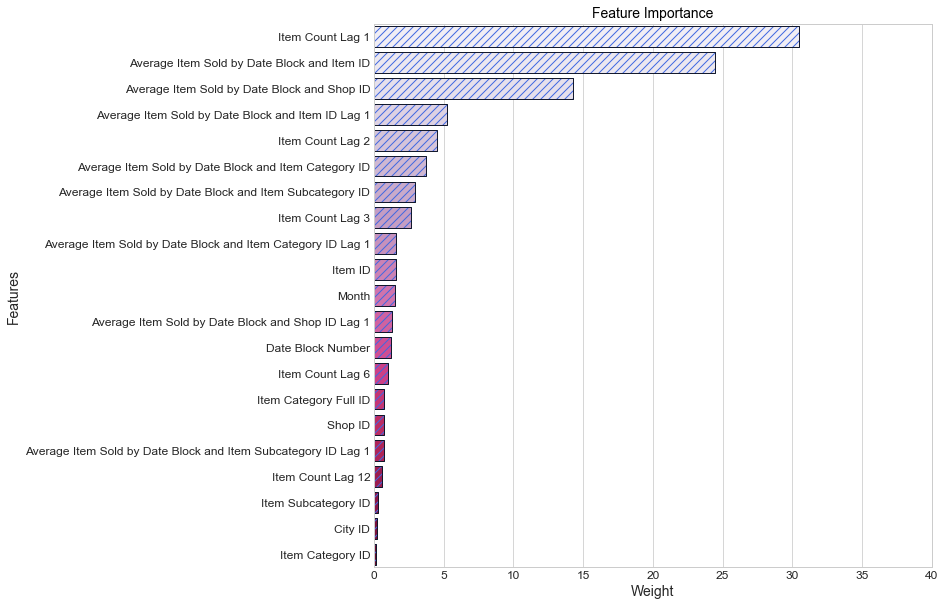

In [24]:
feat_importance = pd.DataFrame(list(zip(X_train.dtypes.index,
                                        model.get_feature_importance(Pool(X_train, label=y_train)))),
                               columns=['Features','Weight']).sort_values('Weight', ascending = False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
_ = sns.barplot(y="Features", x="Weight", palette="PuRd", edgecolor = 'RoyalBlue', hatch = '///',
                data = feat_importance, ax = ax)
_ = sns.barplot(y="Features", x="Weight", facecolor = 'None', edgecolor = 'Black', data = feat_importance, ax = ax)
_ = ax.set_xlim([0,40])
_ = ax.set_title('Feature Importance')

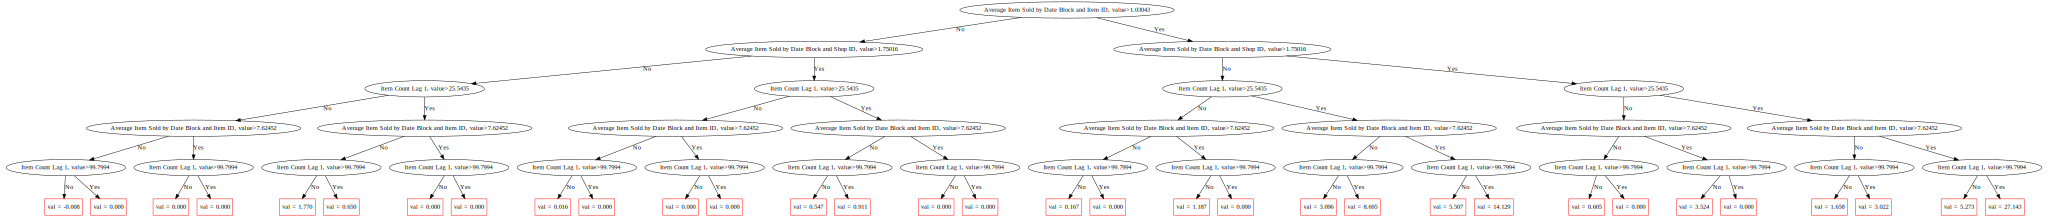

In [25]:
model.plot_tree(tree_idx=0, pool=Pool(X_train, label=y_train))

The best result for each metric calculated on each validation dataset.

In [26]:
display(pd.DataFrame(model.get_best_score()))

,learn,validation
RMSE,0.695253,1.571428


R2 Score

In [27]:
display(pd.DataFrame({'Train Set': {'R2 Score': model.score(X_train, y_train)},
 'Validation Set': {'R2 Score': model.score(X_valid, y_valid)}}))

,Train Set,Validation Set
R2 Score,0.829919,0.645878


# Predictions

In [28]:
Sub = pd.DataFrame({"ID": Test.index.tolist(), "item_cnt_month": model.predict(X_test)})

## Saving to a File

In [29]:
Sub.to_csv(os.path.join(PATH, 'Catboost_sub.csv'), index=False)

***